In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## The TensorFlow Tutorial I wish I had

This notebook is adapted from notes that I took when learning TensorFlow. It provides a slow, thorough introduction to the fundamentals of TensorFlow, answering questions like: What exactly is TensorFlow? Why do we need it? How does the computation graph work? What are operations, variables, placeholders, and sessions?

It assumes you know a good amount of Python. It starts from scratch with TensorFlow, but does _not_ teach `numpy` or linear algebra; you won't necessarily need those skills to follow this tutorial, but understanding `numpy` basics, and how to "vectorize" your code, is an important skill for data scientists. Feel free to ask about resources for this if you're curious!

## What exactly does TensorFlow do?

What is TensorFlow and what exactly does it do? Why do we need it? Why can't we do deep learning with pure Python or `numpy`? To answer these questions, you need to understand the problems TensorFlow trying to solve.

### Python's limitations
Python is what's known as a _dynamically typed_ programming language. This means that while your program is running, it stores in memory (alongside each variable) information about a variable's type. When you run `x + y` in Python, for example, Python's runtime looks up `x`'s type, `y`'s type, then figures out how to add those two things together, or throws an error if it doesn't know how. (For example, try adding a list and a string.) This is called a _runtime type check_. 

This automatic bookkeeping makes Python a pleasure to use, but also leads to inefficiencies. If we store a long list of numbers, for instance, we must allocate memory not just for the data itself but for each number's metadata (type information). If we then want to _sum_ the list, using a loop, for instance, we need to do type checks for every addition operation we perform. This makes pure Python nearly unuseable for processing large datasets.

### Numpy for fast arithmetic
That's where `numpy` comes in. In pure Python, a list is a Python object that holds other Python objects, each with its own metadata. The `numpy` package, on the other hand, exposes a new kind of list, called a _`numpy` array_, that holds values _all of the same type_. Since a `numpy` array must hold values only of one type, we can store the metadata _once_ for the whole array, instead of separately for each element. 

Furthermore, since `numpy` array elements are all of one type, they are all guaranteed to be the same size in memory, which allows us to store them more compactly and access them more quickly. (In pure Python, if you stored all elements "next to each other" in memory, it would be costly to calculate, say, where in memory the 100th item started, as this would depend on the sizes of each previous object. So Python actually stores elements all over the place in memory, then keeps an "index" of the memory locations of each element of the array. This means to sum 100 elements, Python needs to look in the index 100 times and go all over your RAM to find the numbers you want to add. Numpy just stores the 100 items in a row, and since they're all the same size, it's easy to calculate where the 5th or 100th or 1000th item is pretty much instantly.) 

In addition to this compact array type, `numpy` provides a number of operations, implemented in C, that manipulate these arrays, taking advantage of their compact representation. Arrays can be multidimensional, so when we talk about operations on arrays, that includes what you might think of as matrix operations (like fast matrix multiplication) too.

`numpy` is wonderful, and enables Python programmers to work efficiently with vast amounts of data. It is the foundation of higher-level packages like `pandas` and `scipy`. But `numpy`'s design choices make certain tradeoffs; `tensorflow` makes a different set of choices and accordingly has a different set of tradeoffs.

### Downsides of numpy
Even though single `numpy` operations are blazing-fast, when _composing_ `numpy` operations, things can get a bit slower, because between each operation, you still have to go back and forth between Python's intepreter and `numpy`'s C code. Especially when inspecting `numpy` values using, say, `print`, or logging them to files, you incur a cost, because a full translation must be made between the `numpy` value you are converting and the corresponding pure Python type that can interact with other Python code.

The second downside of `numpy` really applies only to deep learning applications. The classic algorithm for training a deep model is (stochastic) gradient descent using backpropagation, which requires taking lots of derivatives. Before TensorFlow and other similar libraries, programmers manually (i.e., using pen and paper) did the calculus, deriving the symbolic gradient of the function to be minimized, then writing special code to take partial derivatives at an arbitrary input point. This is mechanical work that a computer should be able to do automatically. But `numpy`'s structure does not provide an easy way of computing these derivatives automatically. Why? Automatically computing the derivative of some formula requires having some representation of that formula in memory. But when you run `numpy` operations, they simply execute and return their results; no trace is left of the steps used to get from first input to final output. There is no easy way to go back and compute derivatives later on in a program.

### Enter TensorFlow
TensorFlow solves both these problems with the idea of a **computation graph**. Unlike in `numpy`, where  data goes back and forth between Python and C for each operation, in TensorFlow, the programmer creates, in pure Python, an object-oriented representation of the entire computation she wishes to perform. This representation is called a "graph," in the graph theory sense: the nodes in the graph are operations, and the edges represent the data flowing from one operation to the next. Building the graph is like writing down a formula. No data is actually being processed. As such, all of TensorFlow's graph-building functions are lightweight and fast, simply creating a description of computation in memory. Once the graph is complete, it is sent to TensorFlow's low-level execution algorithm. That algorithm, written (like much of `numpy`) in C and C++, performs _all_ the requested operations at once, then returns any values of interest (as specified by the user) back to the Python world.

Because an entire graph of computation is processed at once, there is much less shuttling back and forth between one representation and another. And because the computation graph is essentially an in-memory record of every step used to compute each value in your program, TensorFlow is able to do the necessary calculus automatically, computing gradients based on the structure of that graph.

## The default graph, operations, and tensors

Let's get started by importing TensorFlow.

In [2]:
import tensorflow as tf

Even before you call your first TensorFlow function, a lot is going on behind the scenes. For example, an empty _default graph object_ is created. (In order to make it easier to hit the ground running with TensorFlow, and to make using the library less verbose, Google has laced the system with global state. In order to fully understand what's happening in your program, you need to know that these state variables, like "current graph" and "current scope" and "current session", exist. As we'll soon see, most of the functions you'll call in TensorFlow operate by quietly accessing this hidden state.)

We can access the default graph explicitly using `tf.get_default_graph`:

In [3]:
g = tf.get_default_graph()
g

It is currently empty. We can check this fact by listing the operations (nodes) in the graph:

In [4]:
g.get_operations()

[]

Let's start adding some operations to `g`. An **operation** is a _node_ of the computation graph. It contains only some light metadata, like "I am an addition operation, and my inputs come from these two other operations." Although Python `Operation` objects don't actually _do_ anything, we usually think of an operation in terms of what it will _cause the execution engine to do_ after the graph has been completely built and is handed over to TensorFlow to run.

Every operation takes in some number of inputs (0 or more), and produces 0 or more outputs. Its outputs can become the inputs to other operations. Executing an operation can also have side effects, like printing something to the console, recording data to a file, or modifying a variable in memory. Again, all this computation happens _after_ the graph has been completely built. The Operation object itself is simply a _description_ of computation that will take place.

Perhaps the simplest operation we can create is `constant`. It has zero inputs and one output. When we create a constant operation, we define what that constant output will be (this is stored as metadata on the Operation object we create). TensorFlow's `tf.constant` function creates a constant operation and adds it to the default graph:

In [5]:
tf.constant(3.14)
g.get_operations()

[<tf.Operation 'Const' type=Const>]

`g` now has a `Const` operation! Note that `tf.constant` affected the graph `g`, even though we didn't explicitly say we wanted the constant operation to be added to `g`. It is possible to add operations to a specific, non-default graph, but most of the time, we add directly to the default graph, using functions like `tf.constant`. In fact, we generally don't even call `get_default_graph` to give `g` a name; we just use it implicitly.

Let's examine the constant operation we created. We can use the `inputs` and `outputs` attributes of the operation to confirm that there really are zero inputs and one output.

In [6]:
const_operation = g.get_operations()[0]
len(const_operation.inputs), len(const_operation.outputs)

(0, 1)

Those inputs and outputs are of type `Tensor`. 

In [7]:
const_tensor = const_operation.outputs[0]
const_tensor

<tf.Tensor 'Const:0' shape=() dtype=float32>

A `Tensor` is a lightweight Python object that represents a piece of data flowing along the edges of our graph. That data can be a scalar, a vector, a matrix, or a higher-dimensional array. (The dimensionality of a tensor `t` is accessible as an attribute: `t.shape`. Here, a shape of `()`, Python's empty tuple, means that `t` is a scalar.) The tensor's data is not actually stored inside the Tensor object, and in fact does not exist in Python at all. `t` does not know it will refer to the value `3.14`. A Tensor is just a lightweight way to _reference_ a piece of data that _will_ be computed by TensorFlow's execution engine.

All tensors are the outputs of some operation already in the graph. We use Tensors for two things:
1. When we eventually tell TensorFlow to _run_ our computation graph, we need to let it know which of the many intermediate values we actually want it to report back to us. To do this, we pass in a list of tensors, references to specific values it will compute, that we wish it to "fetch."
2. When we create operations with _inputs_, we need to tell them which _other operations' outputs_ to consume. To do this, we specify input tensors.

To see this in action, let's create another constant operation, then an addition operation that consumes the output tensors of each constant and sums them. First, we call `tf.constant` to create our second constant. As a convenience, the `tf.constant` function actually returns the output tensor of the constant operation it creates:

In [8]:
another_const_tensor = tf.constant(1.414)
another_const_tensor

<tf.Tensor 'Const_1:0' shape=() dtype=float32>

In [9]:
g.get_operations()

[<tf.Operation 'Const' type=Const>, <tf.Operation 'Const_1' type=Const>]

Now, there are two operations in the graph. TensorFlow has named them `'Const'` and `'Const_1'`, but you can also give them names yourself by passing a `name` keyword argument to the `tf.constant` function. Tensors are named following the formula `op_name:output_number`, so `Const_1:0` means "the 0th output of the Const_1 operation."

Let's create an addition operation to add the two tensors together, using `tf.add`. Again, this creates an operation in the default graph, and returns a reference to the operation's output -- a tensor.

In [10]:
sum_tensor = tf.add(const_tensor, another_const_tensor)
sum_tensor

<tf.Tensor 'Add:0' shape=() dtype=float32>

In [11]:
g.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'Add' type=Add>]

In [12]:
add_op = g.get_operations()[2]
len(add_op.inputs), len(add_op.outputs)

(2, 1)

It should make sense that `add_op` has two inputs and one output.

## Running computations using `tf.Session`

In order to _execute_ your computation graph, you need to create a `Session` object. A Session object stores a reference to the graph to execute, some configuration information (determining, for instance, how much memory TensorFlow should allocate on your GPU), and storage for stateful components of your computation graph (which must be kept around across multiple executions of the graph). We haven't talked about any "stateful components" yet, so it's okay if that piece doesn't make sense yet. We'll see Variables, the simplest stateful component, very soon.

You can create a session using the `tf.Session` constructor. It can take in a `graph` parameter, but if you omit it, the session will use the default graph.

In [13]:
# This piece is only necessary so as not to use up an ungodly amount of GPU memory:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# This is the actual code creating the session. You can omit the config arg
# if you have no configuration to do.
sess = tf.Session(config=config)

In [14]:
sess.graph == g

True

The `run` method of the `Session` class is used to send your graph to the computation engine and execute it. As an argument, we pass a tensor we'd like to "fetch" the value of. Based on which tensor we'd like to compute, TensorFlow will calculate a path through the graph, and then execute only the parts of the graph necessary to compute our desired tensor.

In [15]:
sess.run(sum_tensor), sess.run(const_tensor), sess.run(another_const_tensor)

(4.5539999, 3.1400001, 1.414)

Above, we call `sess.run` three times, which invokes the execution engine three times. There is no memoization; each time you call `sess.run`, everything is computed anew. Because of this, if you want to fetch more than one tensor, it's more efficient to fetch them all in one go, by passing a list to `sess.run`. You can also pass a dictionary, a tuple, a named tuple, or nested combinations of these data structures.

In [16]:
sess.run([sum_tensor, const_tensor, another_const_tensor])

[4.5539999, 3.1400001, 1.414]

In [17]:
sess.run({'a': const_tensor, 'b': another_const_tensor, '[a,b,a+b]': [const_tensor, another_const_tensor, sum_tensor]})

{'[a,b,a+b]': [3.1400001, 1.414, 4.5539999], 'a': 3.1400001, 'b': 1.414}

In the last example, TensorFlow created a copy of the `fetches` data structure, but with each tensor replaced by its actual value, computed during execution.

When you're done with a session, you should close it, to free any resources it's keeping track of:

In [18]:
sess.close()

Sessions are more powerful than this, but to understand why, we need to talk about **placeholders** and **variables**.

## Placeholders

Our program above is a bit rigid. If we wanted to perform the exact same addition calculation on different inputs, we would need to create a whole new trio of operations; we have no power to abstract. Placeholders fix this. A placeholder operation, just like a constant, has 0 inputs and 1 output. However, instead of fixing the output value when you define the operation, we pass the placeholder's value to `sess.run` when executing the graph. This allows us to execute the same graph multiple times with different placeholder values.

To add a placeholder operation to the default graph, we use `tf.placeholder`, passing in the _type_ of the value we'd like the placeholder to hold. Valid types include `tf.int8`, `tf.bool`, `tf.float32`, and a whole lot more. See [the documentation](https://www.tensorflow.org/programmers_guide/dims_types) for a complete list. Like `tf.constant`, `tf.placeholder` returns a tensor (the output of the placeholder). We'll make a graph for adding two floats.

In [19]:
a = tf.placeholder(tf.float32)
a

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=float32>

In [20]:
b = tf.placeholder(tf.float32)
flexible_sum_tensor = tf.add(a, b)

In [21]:
g.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'Add' type=Add>,
 <tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'Add_1' type=Add>]

When we call `sess.run`, we now pass in a second argument, `feed_dict`. This is a Python dictionary in which the keys are placeholder tensors (i.e., the outputs of placeholder operations) and the values are numbers, numpy arrays, or Python lists. (Numbers, lists, and numpy arrays can all be converted automatically into a data format compatible with TensorFlow's execution engine.) Note that the keys of `feed_dict` are the actual tensor objects, not strings.

In [22]:
sess = tf.Session(config=config)
sess.run(flexible_sum_tensor, feed_dict={a: 1., b: 2.})

3.0

In [23]:
sess.run(flexible_sum_tensor, feed_dict={a: [1.], b: [2.]})

array([ 3.], dtype=float32)

In [24]:
sess.run(flexible_sum_tensor, feed_dict={a: [[1., 2.], [3., 4.]], b: [[5., 6.], [7., 8.]]})

array([[  6.,   8.],
       [ 10.,  12.]], dtype=float32)

In [25]:
sess.close()

A few things to note:
1. We were able to fetch the same tensor multiple times but with different feed_dict arguments.
2. The placeholder's dimension is dynamic. (You can optionally specify a static dimension when defining a placeholder, by passing a `shape` argument to `tf.placeholder`.)
3. The add operation works much like numpy's add operation, in that it can add (element-wise) two multidimensional arrays. It also supports _broadcasting_, if you're familiar with that from the `numpy` world.
4. When asked to fetch an array (single- or multi-dimensional), TensorFlow returns a numpy array.

As an aside, the Python arithmetic operators ($+$, $-$, $/$, $*$) are overridden for the `Tensor` type. Evaluating the expression $a + b$, where $a$ and $b$ are tensors, has the side effect of adding an `Add` operation to the default graph with $a$ and $b$ as inputs. The result of evaluating $a + b$ is the output tensor of that add operation. This makes it easy to add many nodes quickly. For instance,

In [26]:
distance_from_origin = tf.sqrt((a * a) + (b * b))
g.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'Add' type=Add>,
 <tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'Add_1' type=Add>,
 <tf.Operation 'mul' type=Mul>,
 <tf.Operation 'mul_1' type=Mul>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'Sqrt' type=Sqrt>]

In [27]:
distance_from_origin

<tf.Tensor 'Sqrt:0' shape=<unknown> dtype=float32>

In [28]:
sess = tf.Session(config=config)
sess.run(distance_from_origin, feed_dict={a: 3., b: 4.})

5.0

In [29]:
sess.close()

Another trick: these last three lines can be condensed to two, using Python's `with` feature.

In [30]:
with tf.Session(config=config) as sess:
    print(sess.run(distance_from_origin, feed_dict={a: 9., b: 12.}))

15.0


The session is closed automatically at the end of the `with` block.

Note that trying to call `sess.run(distance_from_origin)` _without_ feeding in `a` and `b` will result in an error. Furthermore, placeholder values are not persistent across multiple calls to `sess.run`, so even if you've previously provided values for `a` and `b` in prior calls to `sess.run`, these are no longer in memory anywhere by the time you make your next `sess.run` call.

One final trick for convenience. Since our graph is getting a bit crowded, we may want to clear it:

In [31]:
tf.reset_default_graph()
g.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'Add' type=Add>,
 <tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'Add_1' type=Add>,
 <tf.Operation 'mul' type=Mul>,
 <tf.Operation 'mul_1' type=Mul>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'Sqrt' type=Sqrt>]

The operations are all still there! That's because `reset_default_graph` doesn't delete operations, it just creates a new graph and makes _it_ the default. `g` still refers to the old graph. We can fix this (and let the old graph be garbage-collected) by reassigning g:

In [32]:
g = tf.get_default_graph()
g.get_operations()

[]

## Variables

Like constants and placeholders, variable operations take 0 inputs and produce 1 output; the big difference is that a variable is _mutable_ and _persistent across runs of your graph_ (within a session). Whereas a constant's value is fixed when creating the graph, and a placeholder's value is set anew each time you call `sess.run`, a variable's value is set or changed _while the graph is running_, by side-effect-ful "assign" operations, and _remembered_ even after `sess.run` is finished. (That memory is in the Session object, which manages stateful components like variables. Calling `sess.close` is necessary to free that memory.)

Let's use `tf.Variable` to add a variable to our new graph, initialized to 42.

In [33]:
x = tf.Variable(42)

In [34]:
# summarize the operations now in the graph:
[(op, "{} inputs and {} output".format(len(op.inputs), len(op.outputs))) for op in g.get_operations()]

[(<tf.Operation 'Variable/initial_value' type=Const>, '0 inputs and 1 output'),
 (<tf.Operation 'Variable' type=VariableV2>, '0 inputs and 1 output'),
 (<tf.Operation 'Variable/Assign' type=Assign>, '2 inputs and 1 output'),
 (<tf.Operation 'Variable/read' type=Identity>, '1 inputs and 1 output')]

Wow -- _four_ operations were just added to the graph! Let's go through them one by one:
1. The first should look familiar. Although it's called `Variable/initial_value`, it is actually just a constant operation. Its output is a tensor that will evaluate to 42.
2. The second is a "Variable" operation. Like placeholder and constant, it has no inputs and one output. But its output type is `int32_ref`, a _mutable_ int32. You can use an `int32_ref` basically anywhere you can use an `int32`. But you can also use it as an input to an _assign_ operation, which is up next.
3. The third operation is an `assign` op. It takes two inputs, a `ref` to a mutable value (almost always the output of a `Variable` op), and a value, then assigns the variable to that value. This `assign` op takes its input from the `Variable/initial_value` constant and the `Variable` ref just discussed. When executed, it has the effect of initializing our variable to to 42. The output is another `int32_ref` tensor, referring to the same mutable storage as the output from (2).
4. Finally, we have an `identity` operation. It takes the variable ref as input and outputs a non-ref `tf.int32`. This isn't necessary in most cases, where it is ok to use the `tf.int32_ref` directly.

$x$, the return value of the `tf.Variable` constructor, is a Variable object, not a tensor, but in practice, you can use it as if it were a tensor. It will either be interpreted as the tensor output of operation (2) above -- the `int32_ref` pointing to the variable's current value -- or of operation (4), depending on context.

Let's start a session and play with our variable.

In [35]:
sess = tf.Session(config=config)

In fact, let's start a _second_ session as well. One of the roles sessions play is to keep track of variable values across executions of the graph, and this will help us visualize that.

In [36]:
sess2 = tf.Session(config=config)

If we attempt to get the value of the variable, we will get an error:

In [37]:
sess.run(x)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: _send_Variable_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=2711890458046951692, tensor_name="Variable:0", _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]

"Attempting to use uninitialized value Variable." In order to initialize the variable, we actually have to run the assign op that was created for us. Recall that this was the third operation in the graph.

If we want to run an operation just for its side effect, not to fetch its output, `sess.run` _does_ support passing in an `op` directly anywhere you would normally pass a tensor (as part of the `fetches` data structure). Here, we'll just pass it standalone:

In [38]:
sess.run(g.get_operations()[2])

In [39]:
sess.run(x)

42

But in `sess2`, $x$ is still not initialized, and running `sess2.run(x)` still gives an error:

In [40]:
sess2.run(x)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: _send_Variable_0 = _Send[T=DT_INT32, client_terminated=true, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=-5768601512910781290, tensor_name="Variable:0", _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]

Let's fix that.

In [41]:
sess2.run(x.initializer), sess2.run(x)

(None, 42)

Notice:
1. Variable objects have an `initializer` property that refers to the `Assign` operation that gives them their initial value.
2. Fetching an _operation_ instead of a _tensor_ performs its side effect but returns `None` -- even if the operation has an output.

Let's return to a blank slate.

In [42]:
sess.close()
sess2.close()

In [43]:
tf.reset_default_graph()
g = tf.get_default_graph()

## Computing gradients

In machine learning, we typically compute some _loss_ function (or _error_) that quantifies how poorly our model is capturing the patterns in the data. In many models, this loss function is _differentiable_, which means we can compute partial derivatives of our loss function with respect to the parameters of our model. These derivatives essentially tell us: as each parameter changes, how does it affect the loss? Given this information, we have an easy way to make the model better: perturb the parameters slightly in the direction that causes the loss to _go down_, according to the partial derivatives. We can do this repeatedly, computing new partial derivatives after each step, until we get to a local minimum. This technique is called "gradient descent."

One benefit of using a computation graph is that Tensorflow can _automatically_ calculate these derivatives for us. More accurately, it can _augment our computation graph_ with operations that compute any derivatives we'd like. To do this, we use the `tf.gradients` function. It takes in two arguments: `ys` and `xs`. `ys` is a tensor or list of tensors we'd like to calculate the derivatives of. `xs` is a tensor or list of tensors we'd like to calculate those derivatives _with respect to_. When called, `tf.gradients` traverses the computation graph backward from `ys` to `xs`, adding for each operation along that path one or more supplemental operations for computing the gradient. These individual-operation gradients can be composed using the chain rule (which `tf.gradients` also takes care of). The return value of `tf.gradients` is a handle to a tensor that represents the answer, $\frac{dy}{dx}$, at the end of that chain.

This will hopefully become clearer with a simple example. Let's create a small graph:

In [44]:
a = tf.constant(5, name='a')
b = tf.constant(7, name='b')
eqn = a + 2 * b
g.get_operations()

[<tf.Operation 'a' type=Const>,
 <tf.Operation 'b' type=Const>,
 <tf.Operation 'mul/x' type=Const>,
 <tf.Operation 'mul' type=Mul>,
 <tf.Operation 'add' type=Add>]

Notice that Tensorflow has added a constant node, `mul/x`, to represent the constant 2. Other than that, this should look as expected: an op for `a` and for `b`, a multiplication, and an addition. (Remember, Python's operations `+` and `*` have been overridden for the tensor type, and they now have side effects of adding operations to the default graph!)

Let's now calculate the derivative of `eqn` with respect to `b`.

In [45]:
grad = tf.gradients(eqn, b)
g.get_operations()

[<tf.Operation 'a' type=Const>,
 <tf.Operation 'b' type=Const>,
 <tf.Operation 'mul/x' type=Const>,
 <tf.Operation 'mul' type=Mul>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'gradients/Shape' type=Const>,
 <tf.Operation 'gradients/Const' type=Const>,
 <tf.Operation 'gradients/Fill' type=Fill>,
 <tf.Operation 'gradients/add_grad/Shape' type=Const>,
 <tf.Operation 'gradients/add_grad/Shape_1' type=Const>,
 <tf.Operation 'gradients/add_grad/BroadcastGradientArgs' type=BroadcastGradientArgs>,
 <tf.Operation 'gradients/add_grad/Sum' type=Sum>,
 <tf.Operation 'gradients/add_grad/Reshape' type=Reshape>,
 <tf.Operation 'gradients/add_grad/Sum_1' type=Sum>,
 <tf.Operation 'gradients/add_grad/Reshape_1' type=Reshape>,
 <tf.Operation 'gradients/mul_grad/Shape' type=Const>,
 <tf.Operation 'gradients/mul_grad/Shape_1' type=Const>,
 <tf.Operation 'gradients/mul_grad/BroadcastGradientArgs' type=BroadcastGradientArgs>,
 <tf.Operation 'gradients/mul_grad/mul' type=Mul>,
 <tf.Operation 'gradients/m

As you can see, a _lot_ of new nodes were added for gradient calculation. The output of the last op listed above will be our derivative, $\frac{d\text{eqn}}{db}$. `tf.gradients` returns that tensor, so we don't have to grab it explicitly:

In [46]:
grad

[<tf.Tensor 'gradients/mul_grad/Reshape_1:0' shape=() dtype=int32>]

We can now execute the graph:

In [47]:
sess = tf.Session(config=config)
sess.run(grad)

[2]

As expected, we get `2`, the partial derivative of `eqn` with respect to `b` at the point `(a=5, b=7)` (at any point, actually, but TensorFlow is computing it at this specific point).

Let's look at a couple variations. If we pass multiple `xs`, we get a _gradient_ back instead of just a _partial derivative_ -- this is a _list_ of partial derivatives.

In [48]:
gradient_wrt_both = tf.gradients(eqn, [a, b])
sess.run(gradient_wrt_both)

[1, 2]

Let's create a second equation.

In [49]:
eqn2 = a * b + b

In [50]:
gradient_of_eqn2 = tf.gradients(eqn2, [a,b])
sess.run(gradient_of_eqn2)

[7, 6]

Remember that `a = 5` and `b = 7`, which is why we get the values we did above. Although you can think of what Tensorflow does as a kind of symbolic differentiation (it constructs a formula, i.e. computation graph, for computing a derivative), it always calculates gradients at a specific point.

If we pass in more than one tensor as the first argument, Tensorflow computes the _sum_ of the derivatives of each of these tensors with respect to the x values, $\sum_{y \in \text{ys}}\frac{dy}{dx}$. In other words, computing `tf.gradients([eqn, eqn2], ...)` below is not too different from `tf.gradients(eqn + eqn2, ...)`, except that the latter actually adds ops to the graph to compute `eqn + eqn2`, whereas the former adds ops to sum the gradients.

In [51]:
gradient_with_two_ys = tf.gradients([eqn, eqn2], [a,b])
sess.run(gradient_with_two_ys)

[8, 8]

Here, `[8, 8] == [7, 6] + [1, 2]`.

In [52]:
sess.close()

In [53]:
tf.reset_default_graph()
g = tf.get_default_graph()

## Optimization

Why do we care about gradients? As mentioned above, being able to compute them so easily opens up the possibility of automatically implementing _gradient descent_, an algorithm that follows derivatives downhill to find a local minimum of some function. In machine learning, we typically want to find the model parameters that minimize some loss, or error, function that measures how bad our model is.

TensorFlow provides amazing tools for doing just that, but to make sure we understand how they work, we'll implement a very simple gradient descent algorithm ourselves. We will be doing something very simple: finding the $x$ that minimizes $x^2$. (Yes, you can do this analytically, or by thinking about it for a second. But this example will bring together some of the ideas we've been discussing about variables and gradients.)

Let's start building our simple computational graph. It will consist of a variable, $x$, which is initialized to 5. It will also contain a "loss function," $x^2$. 

In [54]:
x = tf.Variable(5.0)
loss = x * x
g.get_operations()

[<tf.Operation 'Variable/initial_value' type=Const>,
 <tf.Operation 'Variable' type=VariableV2>,
 <tf.Operation 'Variable/Assign' type=Assign>,
 <tf.Operation 'Variable/read' type=Identity>,
 <tf.Operation 'mul' type=Mul>]

Two start with, we'll calculate our derivative manually, without even using `tf.gradients`. The derivative of $x^2$ at a point is just $2x$:

In [55]:
dloss_dx = 2. * x

We will now create an operation that _changes_ $x$ based on the current derivative of the loss. We can do this using the `tf.assign` function, which creates an operation that assigns a variable to a new value. (The Assign operation has two inputs, the reference to the variable's mutable storage, and the new value we wish to assign. As mentioned in the Variables section, we can pass a Variable object as the first input and TensorFlow will substitute the correct tensor. The Assign operation has one output, the tensor for which is returned by `tf.assign`, which is the new value of the variable after assignment.) 

Because the derivative points in the direction in which our loss is _growing fastest_, we will _subtract_ $x$'s derivative from $x$. (After all, we want the loss to _shrink_, not _grow_.) But rather than subtract the _entire_ derivative, we will subtract a fraction of it. (We generally try not to take large steps in gradient descent; just because the derivative points us in some direction now, doesn't mean that going arbitrarily far in that direction will keep bringing us down the hill. $x^2$ provides a good example: if we are currently at $x=5$, the derivative is $10$, but going $-10$ steps to $-5$ completely steps over the valley we are trying to reach at $x=0$! By multiplying our derivative by a small **step size** of, say, 0.1, we can avoid this fate and progress slowly but almost-surely to our goal.)

In [56]:
step_size = 0.1
new_x_value = x - dloss_dx * step_size
assign_new_x = tf.assign(x, new_x_value)

Our graph is in place. In order to run our algorithm, we need to:
1. Initialize x, by calling `sess.run(x.initializer)`.
2. Repeatedly evaluate the `assign_new_x` operation. (Note: `assign_new_x` is actually a tensor, the output of the assignment operation. Evaluating this tensor will cause the operation to run. If we really wanted to run _just the op_, we could use `assign_new_x.op`; remember that every tensor knows which op it is the output of.)

It is essential that we do all this inside of a single session, because that session is what will keep track of the current value of `x`.

In [57]:
with tf.Session(config=config) as sess:
    # Initialize x:
    sess.run(x.initializer)
    
    # We will fetch the following tensors each iteration
    to_fetch = {'x': x, 'loss': loss, 'derivative': assign_new_x}
    for i in range(100):
        fetched = sess.run(to_fetch)
        
        # every tenth step, print our progress
        if i % 10 == 0 or i+1==100:
            print("Iter {}: {}".format(i, fetched))

Iter 0: {'x': 5.0, 'loss': 25.0, 'derivative': 4.0}
Iter 10: {'x': 0.42949668, 'loss': 0.2882303, 'derivative': 0.42949668}
Iter 20: {'x': 0.057646073, 'loss': 0.0033230698, 'derivative': 0.046116859}
Iter 30: {'x': 0.0061897002, 'loss': 3.8312388e-05, 'derivative': 0.0049517602}
Iter 40: {'x': 0.00066461402, 'loss': 4.4171179e-07, 'derivative': 0.00053169124}
Iter 50: {'x': 7.1362396e-05, 'loss': 5.0925917e-09, 'derivative': 5.7089917e-05}
Iter 60: {'x': 7.6624801e-06, 'loss': 5.8713603e-11, 'derivative': 6.1299843e-06}
Iter 70: {'x': 8.2275255e-07, 'loss': 6.7692179e-13, 'derivative': 6.5820205e-07}
Iter 80: {'x': 8.8342389e-08, 'loss': 7.8043778e-15, 'derivative': 7.0673913e-08}
Iter 90: {'x': 9.4856913e-09, 'loss': 8.9978338e-17, 'derivative': 7.5885529e-09}
Iter 99: {'x': 1.2731479e-09, 'loss': 1.6209056e-18, 'derivative': 1.0185184e-09}


As you can see, the value of `loss` gets closer and closer to 0 as time goes on.

Now let's replace our manual derivative calculation with automatic differentiation, and convince ourselves that nothing changes:

In [58]:
tf.reset_default_graph()
g = tf.get_default_graph()

x = tf.Variable(5.0)
loss = x * x

# tf.gradients is called "gradients" and not "derivative" for a reason: it
# returns a _list_ of partial derivatives, even if you only pass in one x.
# Pull out first element (in our case, the list only has one element).
dloss_dx = tf.gradients(loss, x)[0]
new_x_value = x - dloss_dx * step_size
assign_new_x = tf.assign(x, new_x_value)

In [59]:
with tf.Session(config=config) as sess:
    # Initialize x:
    sess.run(x.initializer)
    
    # We will fetch the following tensors each iteration
    to_fetch = {'x': x, 'loss': loss, 'derivative': assign_new_x}
    for i in range(100):
        fetched = sess.run(to_fetch)
        
        # every tenth step, print our progress
        if i % 10 == 0 or i+1==100:
            print("Iter {}: {}".format(i, fetched))

Iter 0: {'x': 5.0, 'loss': 25.0, 'derivative': 4.0}
Iter 10: {'x': 0.53687084, 'loss': 0.2882303, 'derivative': 0.42949668}
Iter 20: {'x': 0.057646073, 'loss': 0.0033230698, 'derivative': 0.046116859}
Iter 30: {'x': 0.0061897002, 'loss': 3.8312388e-05, 'derivative': 0.0049517602}
Iter 40: {'x': 0.00066461402, 'loss': 4.4171179e-07, 'derivative': 0.00053169124}
Iter 50: {'x': 7.1362396e-05, 'loss': 5.0925917e-09, 'derivative': 5.7089917e-05}
Iter 60: {'x': 7.6624801e-06, 'loss': 5.8713603e-11, 'derivative': 6.1299843e-06}
Iter 70: {'x': 8.2275255e-07, 'loss': 6.7692179e-13, 'derivative': 6.5820205e-07}
Iter 80: {'x': 8.8342389e-08, 'loss': 7.8043778e-15, 'derivative': 7.0673913e-08}
Iter 90: {'x': 9.4856913e-09, 'loss': 8.9978338e-17, 'derivative': 7.5885529e-09}
Iter 99: {'x': 1.2731479e-09, 'loss': 1.6209056e-18, 'derivative': 1.0185184e-09}


The algorithm we have used here is vanilla gradient descent. TensorFlow actually comes with a whole family of optimizers that we can just plug into our model. We do not need to call `tf.gradients` or manually assign a variable at all; TensorFlow can create that whole portion of our computational graph.

To do this, we use one of TensorFlow's premade Optimizer classes. An Optimizer object keeps track of some parameters of the optimization algorithm (like step size, also called learning rate), and has a `minimize` method that can be used to automatically construct the portions of the computation graph that perform gradient computation and gradient descent. Here's how our example from above looks with TensorFlow's `GradientDescentOptimizer`:

In [60]:
tf.reset_default_graph()
g = tf.get_default_graph()

x = tf.Variable(5.0)
loss = x * x

# Create the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
# Add optimize nodes to the graph
minimize_loss = optimizer.minimize(loss)

`minimize_loss` now refers to an operation that runs a single step of gradient descent, updating `x`. (By default `optimizer.minimize` assumes you want to run gradient descent on every `Variable` in the computation graph. If you want to change this, you can pass in a `var_list` argument, specifying exactly which variables should be updated.) Note that before, `assign_new_x` referred to a tensor; `minimize_loss` refers to an actual operation, and `sess.run`ning it will return `None`. Still, it is working, and produces the exact same values as our previous two attempts:

In [61]:
with tf.Session(config=config) as sess:
    # Initialize x:
    sess.run(x.initializer)
    
    # We will fetch the following tensors each iteration
    to_fetch = {'x': x, 'loss': loss, 'train_op': minimize_loss}
    for i in range(100):
        fetched = sess.run(to_fetch)
        
        # every tenth step, print our progress
        if i % 10 == 0 or i+1==100:
            print("Iter {}: {}".format(i, fetched))

Iter 0: {'x': 5.0, 'loss': 25.0, 'train_op': None}
Iter 10: {'x': 0.53687084, 'loss': 0.2882303, 'train_op': None}
Iter 20: {'x': 0.057646073, 'loss': 0.0033230698, 'train_op': None}
Iter 30: {'x': 0.0061897002, 'loss': 3.8312388e-05, 'train_op': None}
Iter 40: {'x': 0.00066461402, 'loss': 4.4171179e-07, 'train_op': None}
Iter 50: {'x': 7.1362396e-05, 'loss': 5.0925917e-09, 'train_op': None}
Iter 60: {'x': 7.6624801e-06, 'loss': 5.8713603e-11, 'train_op': None}
Iter 70: {'x': 8.2275255e-07, 'loss': 6.7692179e-13, 'train_op': None}
Iter 80: {'x': 8.8342389e-08, 'loss': 7.8043778e-15, 'train_op': None}
Iter 90: {'x': 9.4856913e-09, 'loss': 8.9978338e-17, 'train_op': None}
Iter 99: {'x': 1.2731479e-09, 'loss': 1.6209056e-18, 'train_op': None}


There are other optimizers that implement clever variations of gradient descent. For example, here's the popular Adam optimizer:

In [62]:
adam_optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
minimize_loss = adam_optimizer.minimize(loss)
g.get_operations()

[<tf.Operation 'Variable/initial_value' type=Const>,
 <tf.Operation 'Variable' type=VariableV2>,
 <tf.Operation 'Variable/Assign' type=Assign>,
 <tf.Operation 'Variable/read' type=Identity>,
 <tf.Operation 'mul' type=Mul>,
 <tf.Operation 'gradients/Shape' type=Const>,
 <tf.Operation 'gradients/Const' type=Const>,
 <tf.Operation 'gradients/Fill' type=Fill>,
 <tf.Operation 'gradients/mul_grad/Shape' type=Const>,
 <tf.Operation 'gradients/mul_grad/Shape_1' type=Const>,
 <tf.Operation 'gradients/mul_grad/BroadcastGradientArgs' type=BroadcastGradientArgs>,
 <tf.Operation 'gradients/mul_grad/mul' type=Mul>,
 <tf.Operation 'gradients/mul_grad/Sum' type=Sum>,
 <tf.Operation 'gradients/mul_grad/Reshape' type=Reshape>,
 <tf.Operation 'gradients/mul_grad/mul_1' type=Mul>,
 <tf.Operation 'gradients/mul_grad/Sum_1' type=Sum>,
 <tf.Operation 'gradients/mul_grad/Reshape_1' type=Reshape>,
 <tf.Operation 'gradients/mul_grad/tuple/group_deps' type=NoOp>,
 <tf.Operation 'gradients/mul_grad/tuple/control_

Notice that some of the operations Adam has added are Variables! This is because Adam keeps track of certain statistics across iterations, to implement a sort of "momentum." Because of this, before we can run our minimize_loss operation, we need to make sure Adam's variables are initialized. Rather than painstakingly initialize each one, we can use `tf.global_variables_initializer()` to add an op to the graph that initializes _all_ variables created so far.

In [63]:
initialize_all = tf.global_variables_initializer()

In [64]:
with tf.Session(config=config) as sess:
    # Initialize ALL variables
    sess.run(initialize_all)
    
    # We will fetch the following tensors each iteration
    to_fetch = {'x': x, 'loss': loss, 'train_op': minimize_loss}
    for i in range(100):
        fetched = sess.run(to_fetch)
        
        # every tenth step, print our progress
        if i % 10 == 0 or i+1==100:
            print("Iter {}: {}".format(i, fetched))

Iter 0: {'x': 5.0, 'loss': 25.0, 'train_op': None}
Iter 10: {'x': 4.0076041, 'loss': 16.06089, 'train_op': None}
Iter 20: {'x': 3.0603416, 'loss': 9.3656902, 'train_op': None}
Iter 30: {'x': 2.203496, 'loss': 4.8553944, 'train_op': None}
Iter 40: {'x': 1.4757426, 'loss': 2.1778162, 'train_op': None}
Iter 50: {'x': 0.90111959, 'loss': 0.81201649, 'train_op': None}
Iter 60: {'x': 0.48453021, 'loss': 0.23476952, 'train_op': None}
Iter 70: {'x': 0.2120446, 'loss': 0.044962913, 'train_op': None}
Iter 80: {'x': 0.056023382, 'loss': 0.0031386192, 'train_op': None}
Iter 90: {'x': -0.017033529, 'loss': 0.00029014109, 'train_op': None}
Iter 99: {'x': -0.03831948, 'loss': 0.0014683825, 'train_op': None}


As you can see, for our extremely simple problem, Adam hurts more than it helps. Its momentum feature means that the big derivatives from early on in training still have an effect even as we get close to the valley, causing us to overshoot the minimum. Running this for more than 100 iterations would eventually bring us back to 0. (An image that is sometimes used to explain momentum-based optimization approaches vs. typical gradient descent is that if normal gradient descent can be thought of as a man slowly and cautiously walking downhill, momentum-based approaches are better understood as a heavy ball rolling its way downhill. The ball will likely overshoot the bottom then have to roll back down, taking a while to settle. The benefit is that the ball can roll straight past small local minima, and stay immune to certain types of pathological terrains.)

## Machine learning with TensorFlow

So, how do we use all this for machine learning? 

At this point, you're likely ready to move onto any other TensorFlow tutorial you find on the Internet (or in this Github repo). But in case you want to stay here, we'll work our way through a simple example: we'll create a fake dataset of _temperatures_ and _number of hospital visits_ in a fictional city over a number of months. (We assume that colder temperatures lead to more hospital visits.) We'll then fit a linear model to this data. 

The goal of this exercise is for you to see how placeholders, variables, and gradient descent come together to enable fitting a model to some data. Although we'll use a _linear model_ here -- i.e., we assume that the data _y_ can be understood as a linear function of the input $x$ -- the process is the exact same when using a nonlinear model, like a neural network.

### Creating the fake data

Let's begin by creating some fake data for us to train on. We'll make 1000 samples. We generate temperatures according to a normal distribution using `numpy`, then we generate hospital visit numbers according to the formula, `1000 - 5*temps`, plus some random noise.

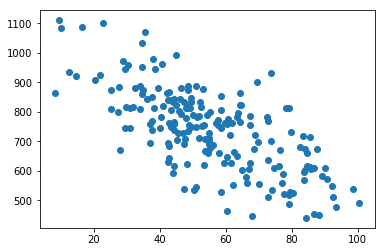

In [65]:
import numpy as np
temps = np.random.normal(55, 20, 1000)
random_noise = np.random.normal(0, 100, 1000)
hosp_visits = 1000 - 5 * temps + random_noise
plt.plot(temps[:200], hosp_visits[:200], "o")

It's common to perform some data cleaning operations on our input data before attempting to use a machine learning algorithm. We'll do that here, subtracting the (empirical) mean and dividing by the standard deviation of the temperature:

In [66]:
normalized_temps = (temps - np.mean(temps)) / np.std(temps)

Now, let's divide the data into training, validation, and test sets.

In [67]:
train_X, train_y = normalized_temps[:800], hosp_visits[:800]
valid_X, valid_y = normalized_temps[800:900], hosp_visits[800:900]
test_X, test_y = normalized_temps[900:], hosp_visits[900:]

Finally, we'll create a "batch generator" for the training set. The following function is a Python _generator function_; instead of returning a value, it continuously _yields_ new batches of data. When we call `batch_generator`, Python creates a _generator iterator_, which we here call `training_generator`, that we can use with Python's `next` function.

In [68]:
def batch_generator(X, y, batch_size):
    total_batches = len(X) // batch_size
    current_batch = 0
    while True:
        start = batch_size * current_batch
        end = start + batch_size
        yield (X[start:end], y[start:end])
        current_batch = (current_batch + 1) % total_batches

training_generator = batch_generator(train_X, train_y, batch_size=100)
# Later, call next(training_generator) to get a new batch of the form (X, y)

### Building the model

Now it's time to build our model. Let's first get a new, empty graph to work with.

In [69]:
tf.reset_default_graph()
g = tf.get_default_graph()

We then set up the major quantities in our model as follows:
1. Our data, the temperatures `X` and the hospital visit numbers `y`, are represented with placeholders. This is so we can fill these values with our actual data at execution time. (You may wonder: why not just put all the data in as a constant? Typically, rather than use Gradient Descent, we use _Stochastic_ Gradient Descent, which means that instead of taking gradients of the loss computed on _all_ our data _every_ iteration, we feed in a small "batch" of data to the graph each iteration of training. This is more efficient, lets us handle large datasets, and provably converges to a local minimum just like normal Gradient Descent. To use this technique, we need placeholders: each time we call `sess.run`, we'll pass in different data.)
2. The parameters of our model, which we hope to _learn_, are represented as TensorFlow variables. This is so that as we run the training operation repeatedly, their current values can change.
3. We then use TensorFlow operations like addition and multiplication to create predicted `y` values based on the `X` values, according to our model. The loss will be computed based on this prediction and its divergence from the true `y`.

In [70]:
X = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
m = tf.Variable(0.)
b = tf.Variable(0.)
predicted_y = X * m + b

### Computing the loss

To compute the loss -- a quantity measuring how bad our model is -- we use sum-of-squares formula: for each data point in the current batch of data, we subtract the real `y` from our `predicted_y` and square the difference; then we take the average of all these. (Taking their sum would work just as well, but by taking the average, we get a number that doesn't depend on the amount of data in a batch, which can be useful for human interpretation and for comparing models with different batch sizes.)

In [71]:
avg_loss = tf.reduce_mean(tf.squared_difference(predicted_y, y))

### Creating an optimizer

Now it's time to actually create our optimization op. We'll use the basic `GradientDescentOptimizer` here, with a learning rate of `0.0005`. (How did we come by this number? Trying different numbers and seeing how the losses looked on the validation set. Feel free to play with this a bit more.)

In [72]:
train_one_step = tf.train.GradientDescentOptimizer(learning_rate=0.0005).minimize(avg_loss)

### Initializing variables and training

Finally, it's time for training. Let's add an op to the graph that initializes all variables, then start a session and run the training code.

In [73]:
init_all_vars = tf.global_variables_initializer()

In [74]:
with tf.Session(config=config) as sess:
    sess.run(init_all_vars)
    for i in range(5000):
        X_batch, y_batch = next(training_generator)
        feed_dict = {X: X_batch, y: y_batch}
        _, loss, m_pred, b_pred = sess.run([train_one_step, avg_loss, m, b], feed_dict=feed_dict)
        if i % 500 == 0:
            validation_feed_dict = {X: valid_X, y: valid_y}
            valid_loss = sess.run(avg_loss, feed_dict=validation_feed_dict)
            print("Iter {}: training loss = {}, validation loss = {}, m={}, b={}".format(i, loss, valid_loss, m_pred, b_pred))
    
    test_feed_dict = {X: test_X, y: test_y}
    m_pred, b_pred, loss = sess.run([m, b, avg_loss], test_feed_dict)
    print("m: {}, b: {}, test loss: {}".format(m_pred, b_pred, loss))

Iter 0: training loss = 582668.5625, validation loss = 540010.0625, m=0.0, b=0.0
Iter 500: training loss = 206951.125, validation loss = 205168.171875, m=-38.86737823486328, b=288.90289306640625
Iter 1000: training loss = 94083.1796875, validation loss = 82282.9609375, m=-62.959327697753906, b=464.12200927734375
Iter 1500: training loss = 33540.421875, validation loss = 37293.37109375, m=-77.47113037109375, b=570.392333984375
Iter 2000: training loss = 24152.564453125, validation loss = 20852.23046875, m=-86.47608947753906, b=634.82666015625
Iter 2500: training loss = 11504.2529296875, validation loss = 14879.8115234375, m=-91.88818359375, b=673.9246215820312
Iter 3000: training loss = 13289.470703125, validation loss = 12722.822265625, m=-95.25810241699219, b=697.612060546875
Iter 3500: training loss = 9052.21875, validation loss = 11956.7099609375, m=-97.27112579345703, b=712.0037841796875
Iter 4000: training loss = 11304.884765625, validation loss = 11689.4150390625, m=-98.536697387

Because the standard deviation of the noise in our data is 100, we expect the average loss to be no better than $100^2$, which is exactly what we see here. The recovered slope and y-intercept (-100, 729) may look strange to you, but remember that we cleaned our data, which changed the meaning of these parameters. Since we divided temperature values by the standard deviation, approximately 20, a slope of -100 is actually a slope of -5 per degree. And since we subtracted the mean temperature, 55, a y-intercept of 729 is actually a y-intercept of 1004 (that is, $729 + m * \text{mean} = 729 + 5 * 55$).